In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# módulo de SciPy
from scipy import signal as sig

# Esta parte de código la agregamos SOLO en los notebooks para fijar el estilo de los gráficos.
fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 13

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

In [1]:
# from pytc2.sistemas_lineales import analyze_sys, bodePlot, pzmap, pretty_print_bicuad_omegayq
from pytc2.general import print_latex, a_equal_b_latex_s

from schemdraw import Drawing
from pytc2.dibujar import dibujar_espacio_derivacion, dibujar_elemento_serie, dibujar_elemento_derivacion, dibujar_puerto_salida, dibujar_puerto_entrada
from pytc2.general import to_latex

<img src="./logo_UTN.svg" align="right" width="150" /> 

### Teoría de Circuitos II
#### Barrionuevo Cecilia

# Tarea Semanal 9

## Parte 1 - Diseño de filtros

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

<img src="./TS9_plantilla.png"/> 


y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo,

b) fase

c) retardo

d) y respuesta al impulso.


## Parte II - Implementación y uso

En esta parte utilizaremos los dos filtros diseñados para mitigar las interferencias.

In [86]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes

import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

from scipy.signal import firls

# Tamaño de las figuras
fig_sz_x = 12
fig_sz_y = 6

# Tamaño de la tipografía
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})

In [87]:

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

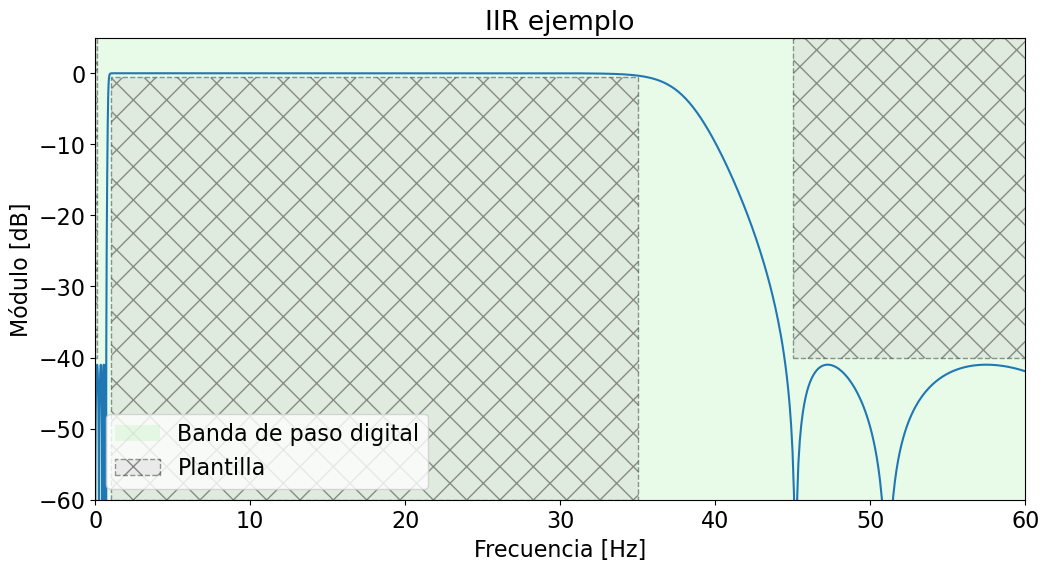

In [88]:
# Genero la Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = .1 #Hz
wp1 = 1 #Hz
wp2 = 35.0 #Hz
ws2 = 45.0 #Hz

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)


plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
_ = plt.legend()

#Primer diseño ==> IIR

sos_iir = sig.iirdesign([wp1-0.1,wp2+0.5], [ws1,ws2], gpass=ripple, gstop=atenuacion+1, output='sos', analog=False, ftype='cheby2', fs = fs)

w_rad  = np.append(np.logspace(-3, 0.8, 1000), np.logspace(0.9, 1.8, 1000) )
w_rad  = np.append(w_rad, np.linspace(64, nyq_frec, 1000, endpoint=True) )

w_rad, h_iir = sig.freqz_sos(sos_iir, worN=w_rad, fs = fs)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w_rad, 20*np.log10(np.abs(h_iir)+1e-12), label = 'IIR' )

plt.title('IIR ejemplo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()



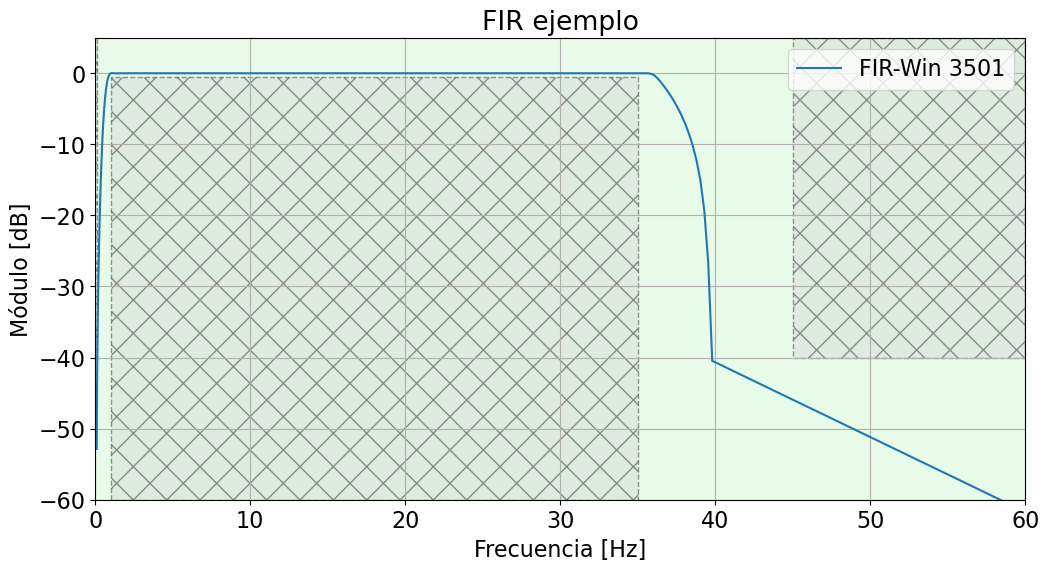

In [89]:
##segundo diseño ==> FIR

# se fija una cantidad de coeficientes para la respuesta del FIR
cant_coeficientes = 3501

# algoritmo de diseño, se obtienen los coeficientes del numerador
num_win = sig.firwin2(cant_coeficientes, freq = (0, ws1+0.45, wp1-0.4, wp2+1 , ws2-5.3, nyq_frec), gain = (0, 0, 1, 1, 0, 0) , window=('kaiser',5) , fs = fs )

#'blackmanharris'
# coeficientes del denominador
den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) )

_, hh_win = sig.freqz(num_win, den, w, fs = fs)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('FIR ejemplo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)


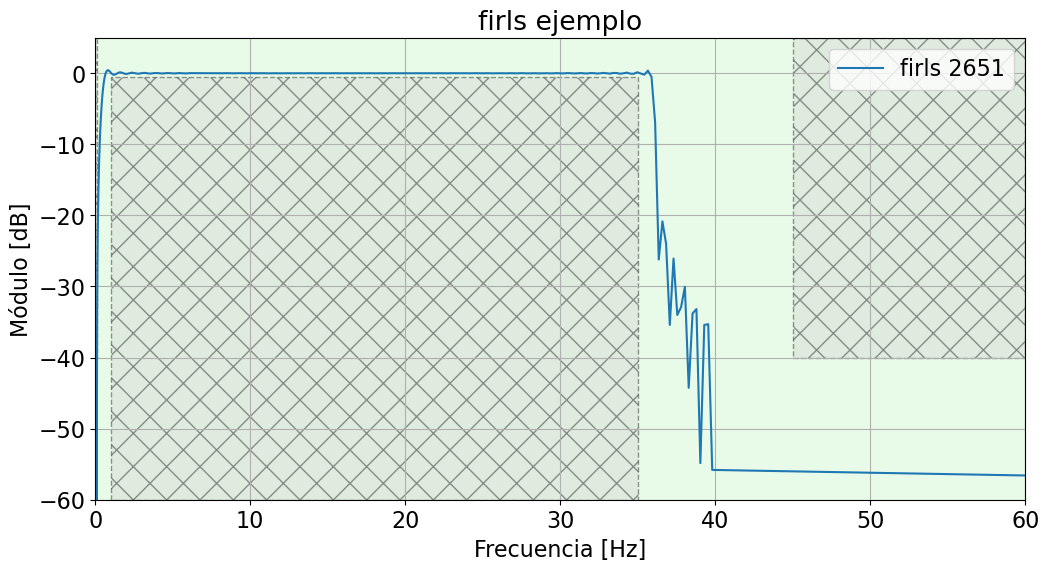

In [90]:
##Tercer Diseño ==> FIR
cuad_coef = 2651
h_firls = sig.firls(cuad_coef, [0, ws1+0.1 ,wp1-0.5, wp2+1, ws2-9, nyq_frec], [0, 0, 1, 1, 0, 0], weight=[100., 10.,1.],fs=fs)


w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) )

den = 1.0
_, hh_firls = sig.freqz(h_firls, den, w, fs = fs)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w, 20 * np.log10(abs(hh_firls)), label='firls {:d}'.format(h_firls.shape[0]))

plt.title('firls ejemplo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)

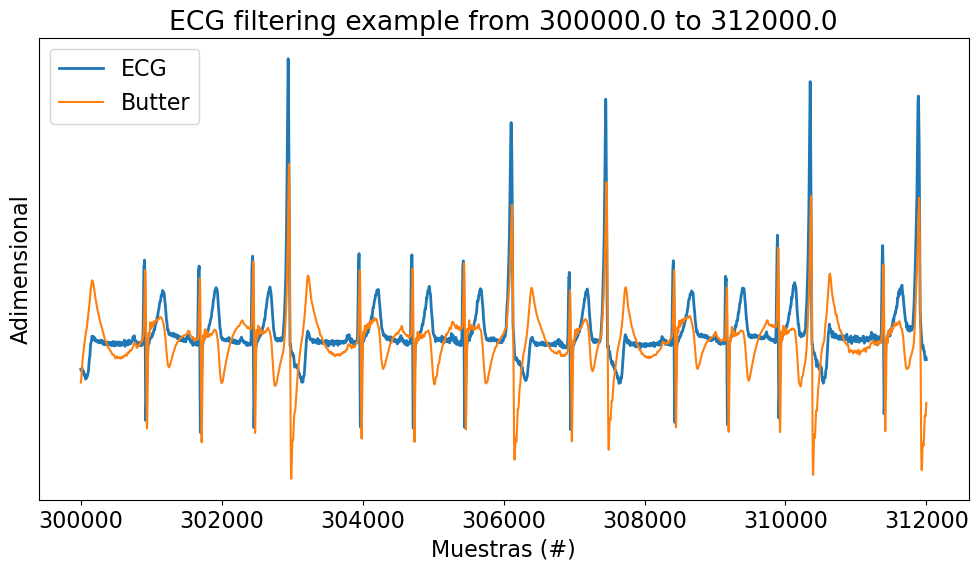

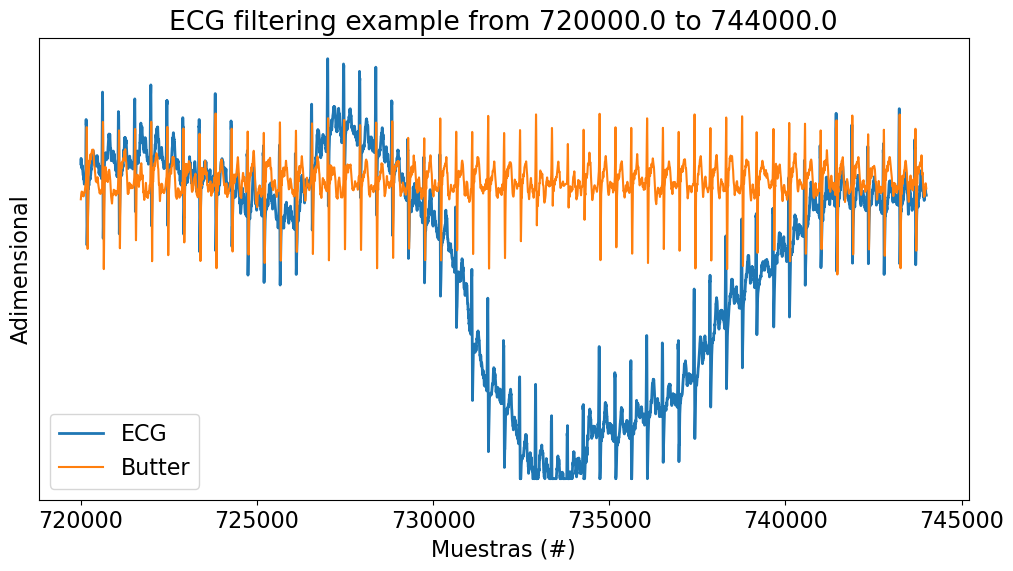

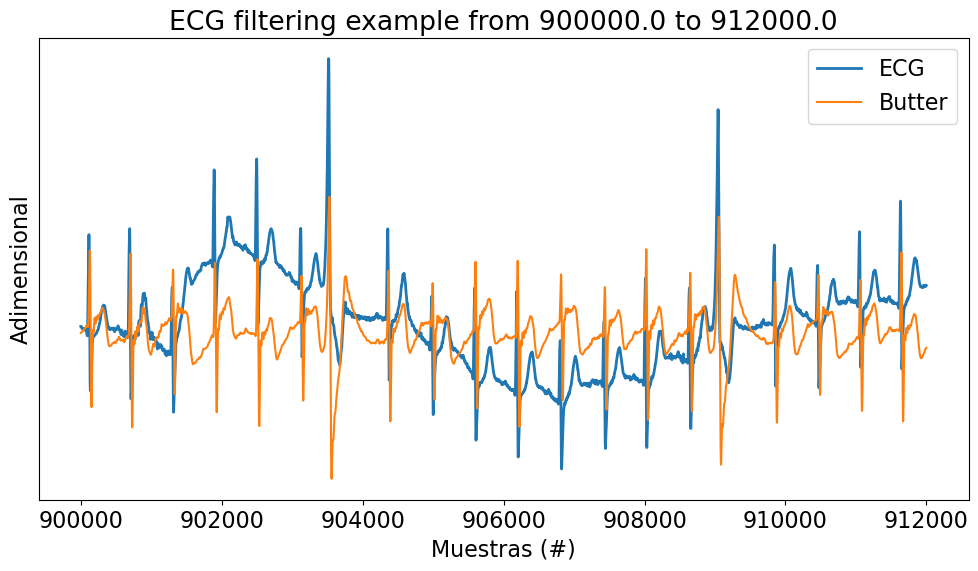

In [113]:

#FILTRO 1 IIR


# IIR
ECG_f_butt = sig.sosfilt(sos_iir, ecg_one_lead)


# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 0
#kaiser : 1750

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

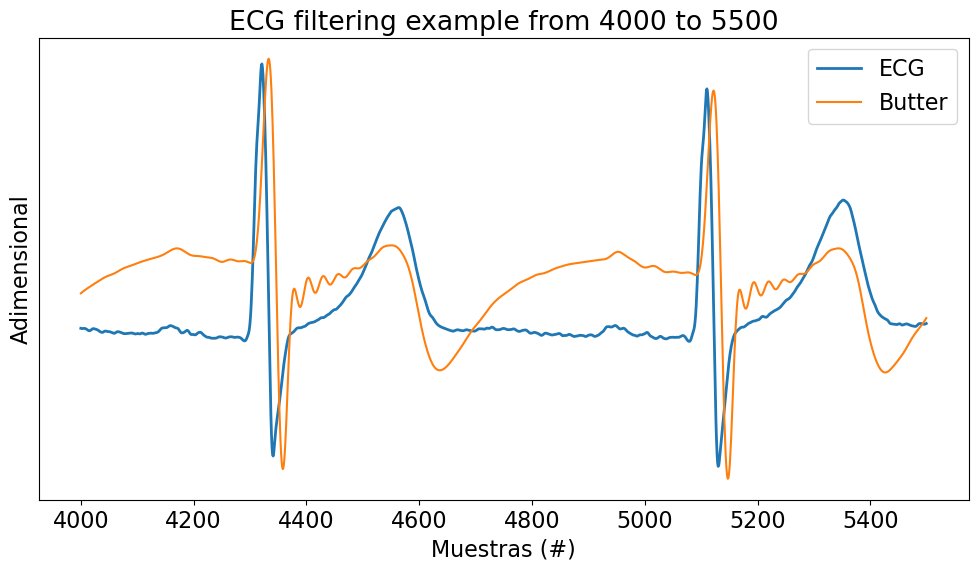

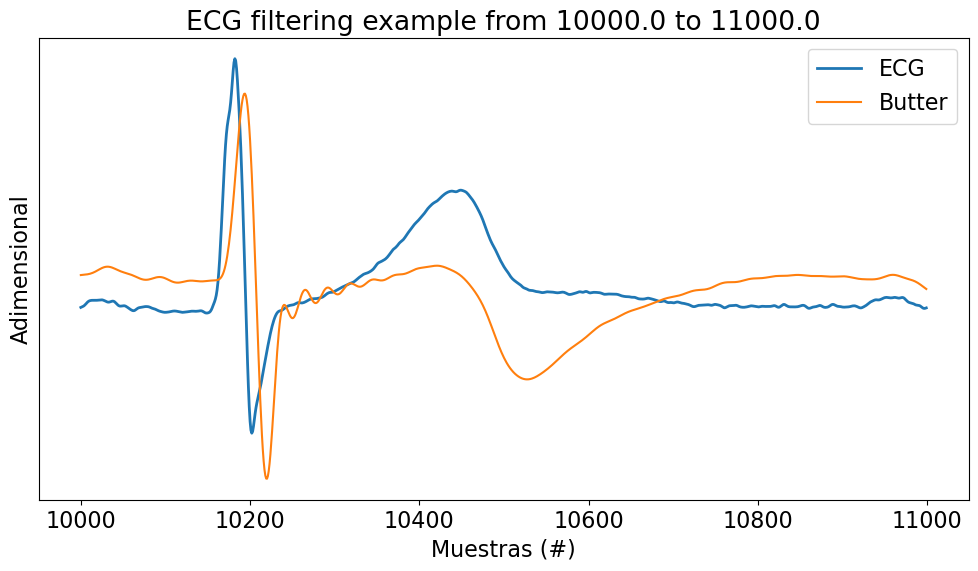

In [116]:


regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

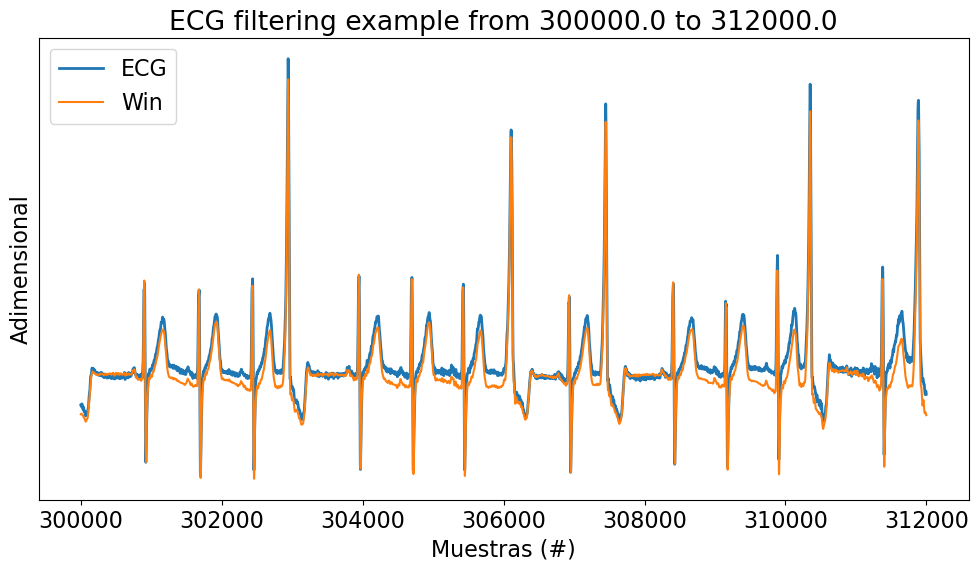

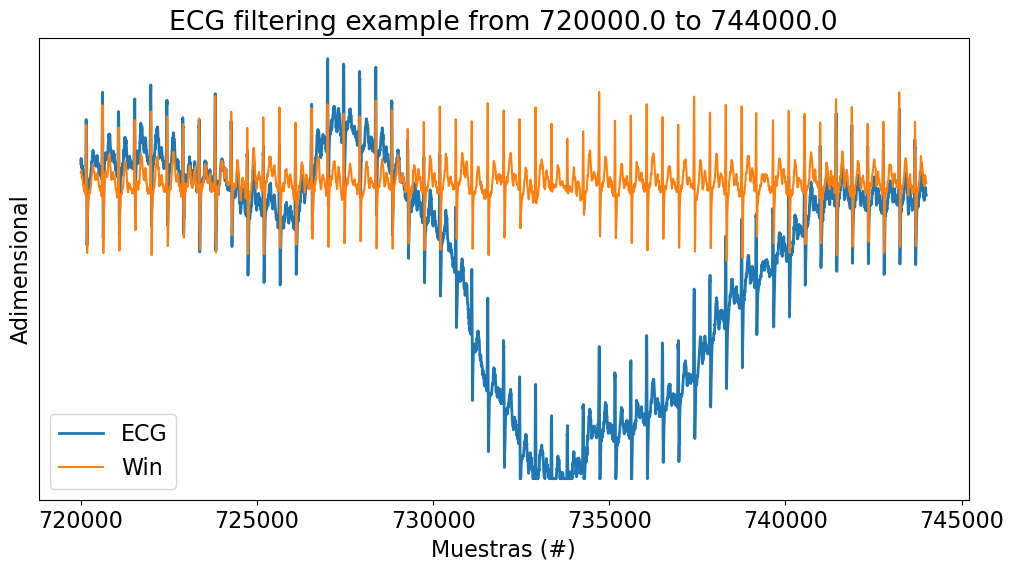

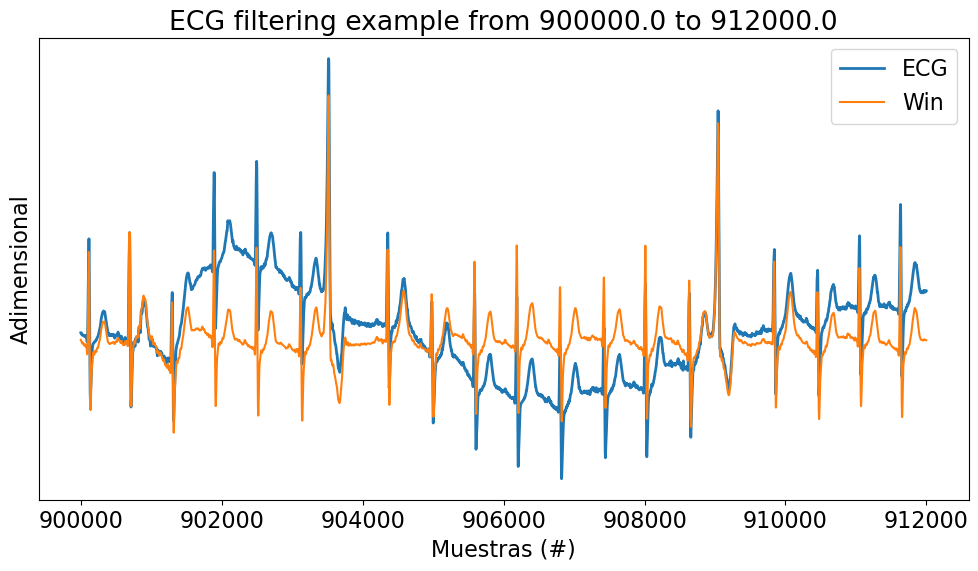

In [98]:

#FILTRO 2 FIR

#ECG_f_win = sig.sosfilt(sos_iir, ecg_one_lead)
#ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)
#ECG_f_win = sig.sosfilt(sos_iir, ecg_one_lead)

# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 0
#kaiser : 1750

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

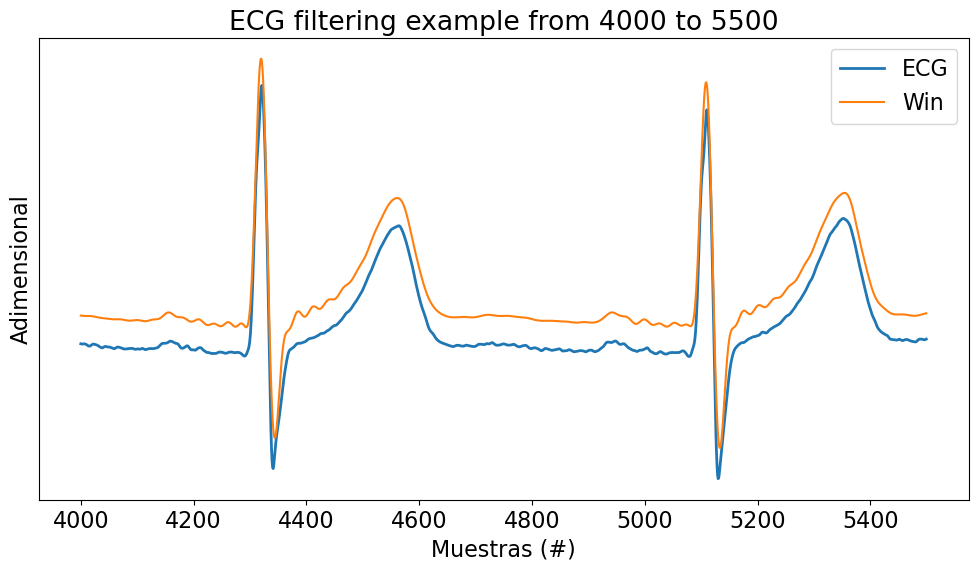

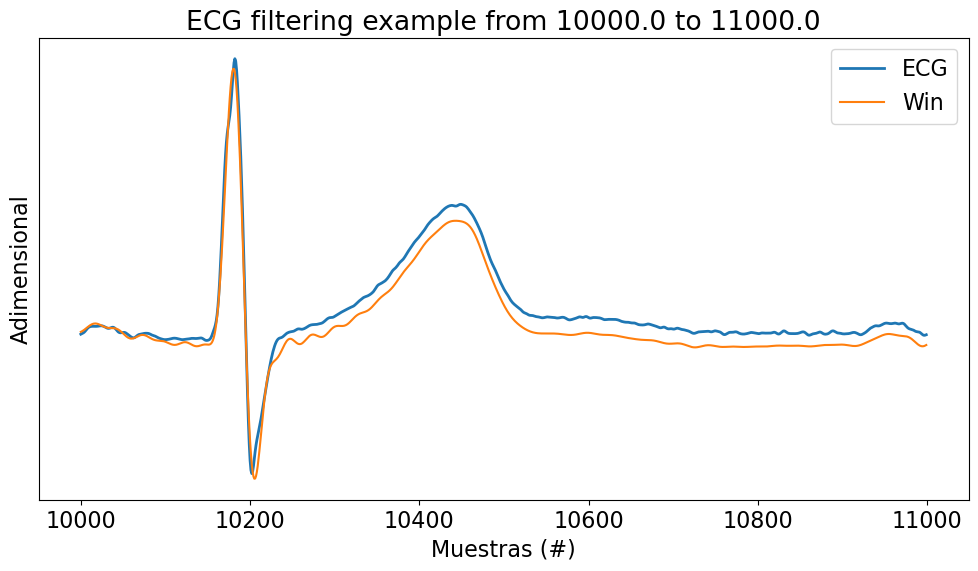

In [99]:


regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

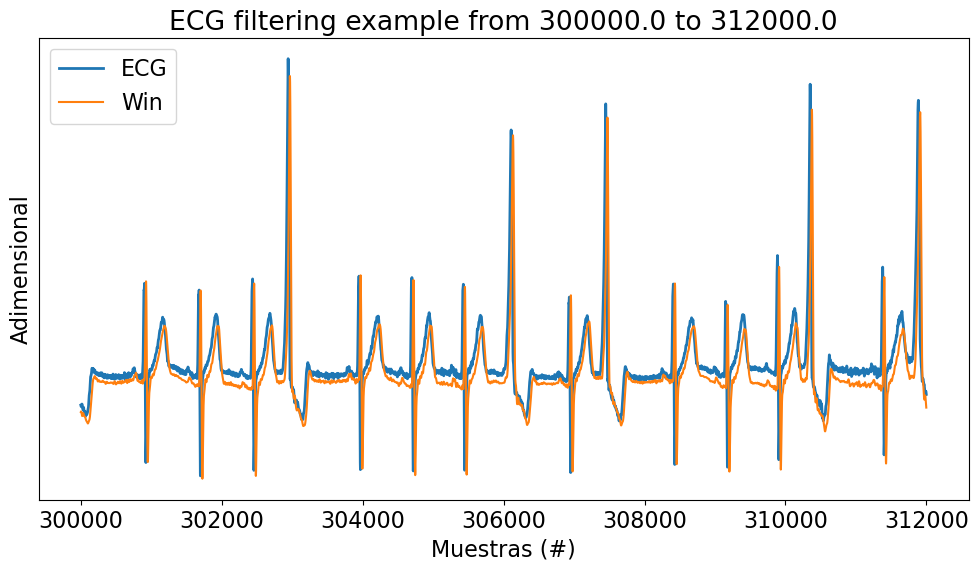

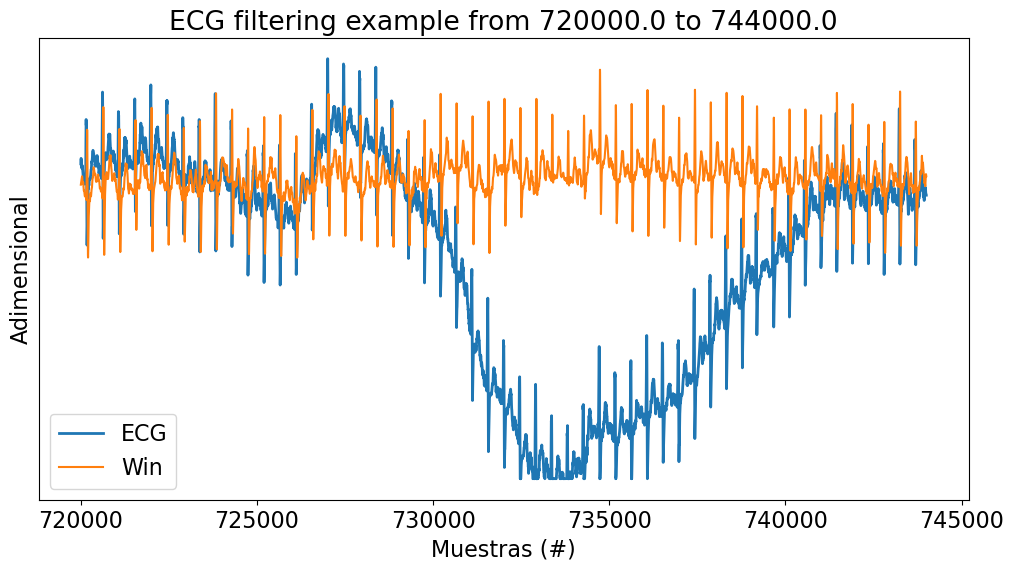

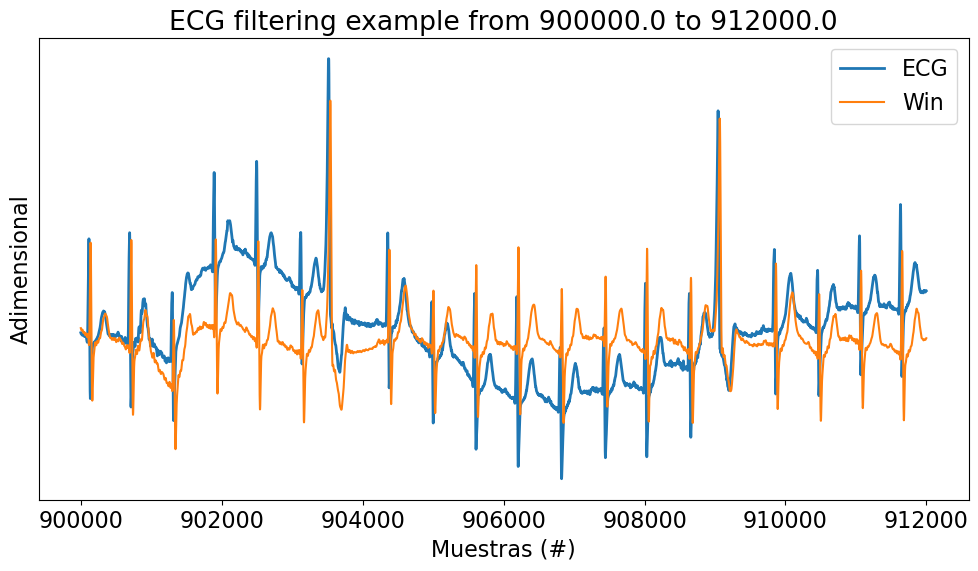

In [111]:

#FILTRO 3 FIR

#ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)


# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)
ECG_f_win = sig.lfilter(h_firls, den, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 1300


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

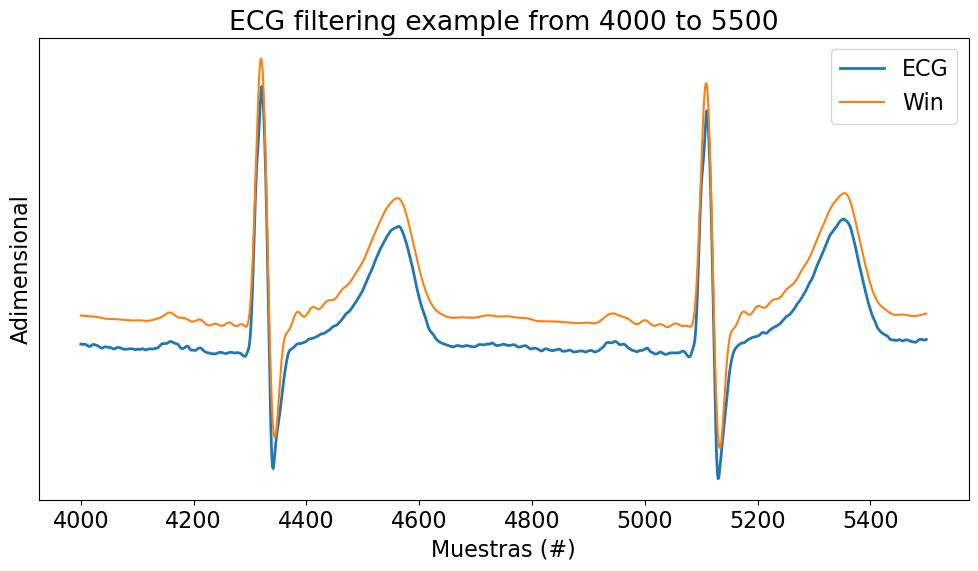

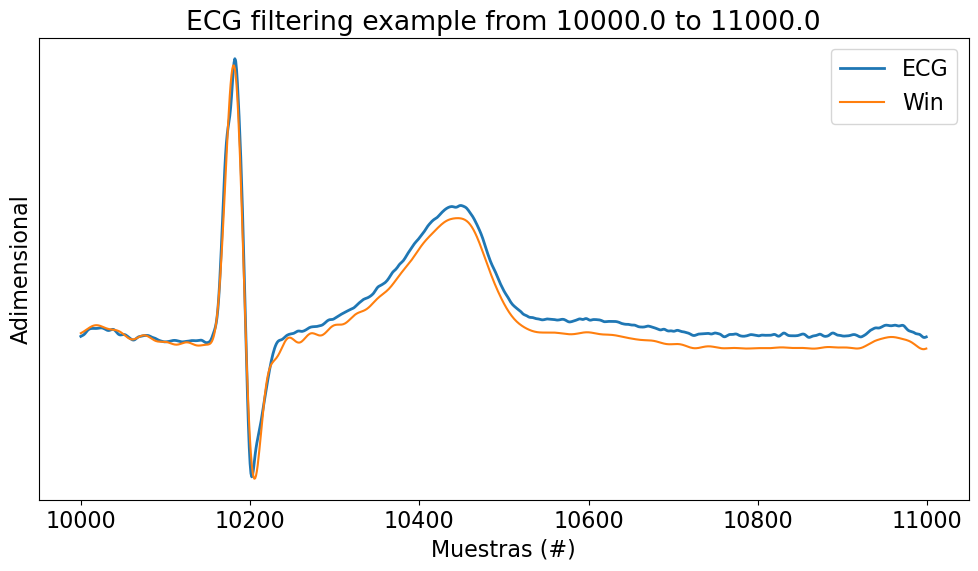

In [108]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()